# Netzwerk und Internet

Miteinander kommunizierende Computer sind eine sehr mächtige Erfindung.
Prominente Beispiele sind lokale Netzwerke, das Internet, das hier vorliegende IPython Notebook, Smartphones und Raumsonden.
Im folgenden wird umrissen, wie man mittels Python mit einem Server kommunizeren kann,
wie Daten übertragen werden, und wie ein Server prinzipiell gestartet werden kann.

Python selbst liefert die Bibliotheken [urllib](https://docs.python.org/2/library/urllib.html) ([Py3 urllib](https://docs.python.org/3/library/urllib.html))
und [urllib2](https://docs.python.org/2/library/urllib2.html) aus.
Sie liefern eine rudimentäre Schnittstelle um mit der Außenwelt kommunizieren zu können.

Besser ist eine Bibliothek wie [requests](http://docs.python-requests.org/en/latest/), welche einfacher zu bedienen ist.

In [1]:
import requests as req

## WWW: HTTP GET requests

Kommunikation im [WWW](http://info.cern.ch/hypertext/WWW/TheProject.html) läuft über das [HTTP Protokol](http://en.wikipedia.org/wiki/HTTP) ab.
Es gibt Verben und Objekte. Das Verb "GET" teilt einem anderen Computer (Server) mit, dass der eine Computer etwas haben möchte.
Die dieser Kommunikation [zugrunde liegenden Systeme](http://en.wikipedia.org/wiki/OSI_model) stellen sicher, dass beide miteinander auch über große Distanzen sprechen können.

Im folgenden Beispiel holen wir uns die Zellen des dieses hier vorliegenden Notebooks vom [Hauptrepository of GitHub](https://github.com/haraldschilly/python-fuer-mathematiker/).
Das Dateiformat basiert auf [JSON](http://json.org) und es werden genau die hier sichtbaren Zellen geladen.

Die `requests` Bibliothek verbindet sich dabei zu GitHub über das Internet, teilt dem Server mit, dass es genau diese Datei haben möchte, und dann verarbeitet es die Rohdaten zu einer JSON Datenstruktur mittels `.json()`.
Anschließend eine kurze Suche nach dem Inhalt "vorliegenden Notebook" um genau diese Zelle zu finden und auszugeben.

In [2]:
netzwerk = req.get("https://github.com/haraldschilly/python-fuer-mathematiker/raw/master/doc/4-6-netzwerk.ipynb")
notebook = netzwerk.json()

In [3]:
import json
for cell in notebook["worksheets"][0]["cells"]:
    if any("vorliegenden Notebook" in block for block in cell.get("source", [""])):
        text = "".join(cell["source"])
print(text[:400] + "...")

## WWW: HTTP GET requests

Kommunikation im [WWW](http://info.cern.ch/hypertext/WWW/TheProject.html) läuft über das [HTTP Protokol](http://en.wikipedia.org/wiki/HTTP) ab.
Es gibt Verben und Objekte. Das Verb "GET" teilt einem anderen Computer (Server) mit, dass der eine Computer etwas haben möchte.
Die dieser Kommunikation [zugrunde liegenden Systeme](http://en.wikipedia.org/wiki/OSI_model) stelle...


## HTML

Webseiten sind in [HTML](http://en.wikipedia.org/wiki/HTML) formatiert.
Die Rohdaten sind ähnlich wie XML in Tags eingeschlossene Textbausteine.
Eine Bibliothek wie [Beautiful Soup](http://www.crummy.com/software/BeautifulSoup/) hilft,
diese Tags einzulesen und als Datenstruktur zu bearbeiten.
Holen wir zum Beispiel die aktuellen Nachrichten, extrahieren ausschließlich die Überschriften des Hauptbereichs, und modifizieren die Links so, dass sie auf die Originalseite verweisen und ein neues Tab öffnen:

In [4]:
from bs4 import BeautifulSoup
derstandard = BeautifulSoup(req.get("http://derstandard.at").text)

In [5]:
from IPython.display import HTML
headlines = derstandard.select("div#documentCanvas h2 a") + derstandard.select("div#documentCanvas h3 a") 
hl_list = BeautifulSoup("<ul>")
for hl in headlines:
    hl.attrs["href"] = "http://derstandard.at" + hl.attrs["href"]
    hl.attrs["target"] = "_blank"
    entry = hl_list.new_tag("li")
    entry.append(hl)
    hl_list.append(entry)
HTML(hl_list.prettify())

## Suchmaschine

Eine Kombination aus den bisher vorgestellten Techniken
ist z.B. der Bau einer eigenen kleinen Suchmaschine.
Zuerst werden Webseiten nach Links durchsucht,
und die verlinkten Seiten ebenfalls wieder nach Links durchsucht.
Auf diese Art erhält man eine Sammlung von Webseiten.

Dafür baut man nun einen Index,
der von den einzelnen Wörtern einer Seite wieder auf den jeweiligen Link
der Webseite zurück verweist.

Offen ist noch, welche von den Webseiten,
die den Suchbegriff enthalten,
besonders wichtig sind.
Eine Technik, ursprünglich von Google's CEO Larry Page und nach ihm benannt,
ist [PageRank](http://infolab.stanford.edu/pub/papers/google.pdf).
Es analysiert die Struktur aller Links untereinander
und gewichtet diejenigen Seiten besonders hoch,
auf die von höher gewichteten Seiten aus verlinkt werden.

In [6]:
from __future__ import print_function
from collections import defaultdict
from Queue import Queue
import requests as req
import random
import re
import threading
import networkx as nx
from multiprocessing.pool import ThreadPool
from bs4 import BeautifulSoup

In [7]:
def mk_new_url(url, href, url_filter = None):
    if href.startswith("http"):
        if url_filter:
            if url_filter not in href.split("/")[2]:
                return None
        new_url = href
    elif href.startswith("#"):
        return None
    else:
        if not href.startswith("/"):
            href = "/" + href
        new_url = url + href
    if "?" in new_url:
        new_url = new_url[:new_url.index("?")]
    if new_url.endswith("/"):
        new_url = new_url[:-1]
    return new_url

In [8]:
word = re.compile(r"\b\w{4,}\b")

def index_task(url):
    if url in visited:
        return "d"
    try:
        content = req.get(url, timeout = 5).text
    except:
        # connection error, etc. -> pick next one
        return "err"

    page = BeautifulSoup(content)
    for a in page.select("a"):
        if "href" in a.attrs:
            new_url = mk_new_url(url, a.attrs["href"], url_filter)
            if new_url:
                urls.put(new_url)
                link_graph.add_edge(url, new_url)

    for match in word.finditer(page.text):
        token = match.group().lower()
        keywords[token].add(url)

    visited.add(url)
    
    return len(visited)

In [22]:
def get_urls(limit = 400):
    while limit >= 0:
        limit -= 1
        url = urls.get()
        yield url

In [23]:
# Start. Resetting all variables.
urls = Queue()
urls.put("http://plone.mat.univie.ac.at") # start URL
url_filter = "univie.ac.at" # this must be in the DNS name
visited = set()
keywords = defaultdict(set)
# 30 in parallel, most of the time they are waiting for the website!
link_graph = nx.DiGraph()
workers = ThreadPool(30)
for nb_urls in workers.imap_unordered(index_task, get_urls()):
    print(nb_urls, end=" ")
print("END")

1 2 3 4 5 6 7 7 8 9 10 11 d 12 d d 13 d d 14 15 d d d d 16 17 d d d 18 d 19 d d 20 21 22 23 24 25 26 27 28 29 30 d d 31 32 33 34 35 36 d d d d d d d d d d 37 d 38 38 39 d d d d d d d d d 39 39 39 39 40 40 41 41 41 d 41 d d d d d d d 41 d d d 41 d d d d d d d d d d d d d d d d d 42 d 43 d d d d d d d d d d d 43 44 d d d d 44 d d d 44 45 d d d 45 d d 45 d d d d d d d d d d d d d d d d d d d 46 err 46 47 48 48 d 49 50 51 52 53 54 d d d d d d d d d d 55 d 56 d d d d d d d d d d 57 d d d d d d d d d d d d 58 59 60 61 62 d d d d d d d d d 63 d 63 d d d d d d d d d d 63 d d d d d d d d d d 64 65 66 67 67 67 68 d d 69 err 70 71 72 73 d 74 75 76 77 d d d d d d d d d d d d d d d 78 d d d d d d d d d d d d d d d d d d d d d 79 d 80 d d d d d d d d d d d d d d d 81 d d d d d d d d d d d d d d d d d 82 d d d d d 83 d d 83 d d d d d d d d d d d d 83 83 84 84 84 err err err 85 86 87 err 88 88 err err err err 89 err err 90 91 92 93 94 95 96 97 END


### PageRank, top 10

In [24]:
link_weights = nx.algorithms.link_analysis.pagerank(link_graph)
weighted_links = sorted(link_weights.keys(), key=link_weights.get, reverse=True)
for idx, link in enumerate(weighted_links):
    print("%s, %s" % (link, link_weights[link]))
    if idx > 10:
        break

http://bibliothek.univie.ac.at/fb-wirtschaft-mathematik, 0.00447118247308
http://plone.mat.univie.ac.at, 0.00442915042551
http://plone.mat.univie.ac.at/news/finanziell-und-ausstattungsmassug-sehr-attraktiver-ruf-der-purdue-university-an-kollegen-markowich, 0.00437865206002
http://plone.mat.univie.ac.at/talks/calendar, 0.00437865206002
http://plone.mat.univie.ac.at/events/2015/oka-theory-and-the-spectral-nevanlinna-pick-problem, 0.00437865206002
http://plone.mat.univie.ac.at/studium/studienbeginn, 0.00437865206002
http://plone.mat.univie.ac.at/accessibility-info, 0.00437865206002
http://plone.mat.univie.ac.at/events/2015/tba-7, 0.00437865206002
http://plone.mat.univie.ac.at/sitemap, 0.00437865206002
http://plone.mat.univie.ac.at/news, 0.00437865206002
http://plone.mat.univie.ac.at/links-de, 0.00437865206002
http://plone.mat.univie.ac.at/fakultaet/gaeste, 0.00437865206002


### PageRank Plot (logarithmische Y-Achse)

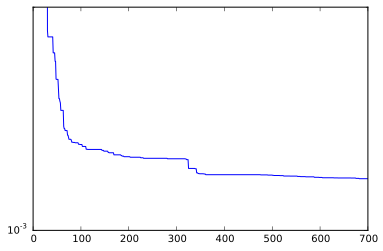

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(sorted(link_weights.values(), reverse=True))
ax = plt.gca()
ax.set_ylim((0.001, 0.002))
ax.set_yscale('log')

In [13]:
def search(*terms):
    from IPython.display import HTML
    
    def get_matches(term):
        urls = set()
        for k in keywords.keys():
            if term in k:
                for url in keywords[k]:
                    urls.add(url)
        return urls
    
    result = get_matches(terms[0])
    for term in terms[1:]:
        result = result.intersect(get_matches[term])

    # sort by pagerank
    result = sorted(result, key = link_weights.get, reverse=True)
        
    urls_html = ['<a href="{0}" target="_blank">{0}</a> ({1:.6e})'.format(r, link_weights[r])
                 for r in result]
    return HTML('<br>'.join(urls_html))

Suche nach Seiten, die das Teilwort "mathemat" beinhalten:

In [14]:
search("bachelor")

In [15]:
len(keywords)

2352

10 zufällig gewählte Schlüsselwörter

In [16]:
random.sample(keywords.keys(), 10)

[u'brannath',
 u'teaching',
 u'stable',
 u'2013',
 u'ilya',
 u'june',
 u'informieren',
 u'helge',
 u'vormals',
 u'benutzbarkeit']